In [80]:
# Imports
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
# # Decision Tree for comparison
from sklearn.tree import DecisionTreeClassifier
# # Used for outputting images from a file
from IPython.display import display, Image

# # If any figures change, set to true
gen_new_plot=False

In [81]:
X = pd.read_csv("X.csv")
y = pd.read_csv("y.csv")

# Section 1B: Initial comparison of KNN versus the Decision Tree

In [82]:
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)

X_train, X_test, y_train, y_test = train_test_split(X, np.ravel(y), random_state=0)

knn = knn.fit(X_train, y_train)
tree = tree.fit(X_train, y_train)
accuracy_knn = knn.score(X_test, y_test)
accuracy_knn_train = knn.score(X_train, y_train)
accuracy_tree = tree.score(X_test, y_test)
accuracy_tree_train = tree.score(X_train, y_train)

print("Accuracy of KNN: ", accuracy_knn, "\nTraining accuracy of KNN: ", accuracy_knn_train)
print("Accuracy of DT: ", accuracy_tree, "\nTraining accuracy of DT: ", accuracy_tree_train)

Accuracy of KNN:  0.4572449207412369 
Training accuracy of KNN:  0.610614857823433
Accuracy of DT:  0.9231971422192453 
Training accuracy of DT:  1.0


# Section 2 : Scaling the Data

Scale the dataset. Additionaly, multiply the "mpg scaled" attribute by a weight of `mpg_weight` to adjust the impact for groupings of this attribute.

In [83]:
scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
columns = X.columns + " scaled"
X_scaled = pd.DataFrame(X_scaled, columns=columns)

In [84]:
# adjust the 'mpg scaled' feature
display(X_scaled.head())

,year scaled,price scaled,mileage scaled,mpg scaled,engineSize scaled,Automatic scaled,Manual scaled,Semi-Auto scaled,Diesel scaled,Electric scaled,Hybrid scaled,Petrol scaled
0,0.875000,0.211101,0.089747,0.203867,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.916667,0.247798,0.051125,0.203867,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.875000,0.229450,0.070113,0.203867,0.2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.958333,0.312018,0.058877,0.107735,0.3,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.958333,0.293670,0.008337,0.154144,0.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [85]:
# X_scaled.to_csv("X_scaled.csv", index=False)

---

# Section 3: Designing the KNN Model

Read the scaled data from files. Store the features and targets to variables. These variables will be used for train-test splitting.

In [86]:
# read scaled data for non-target attributes
X_scaled = pd.read_csv("X_scaled.csv")

# read the target attribute
y = pd.read_csv("y.csv").to_numpy().ravel()

### study interactions

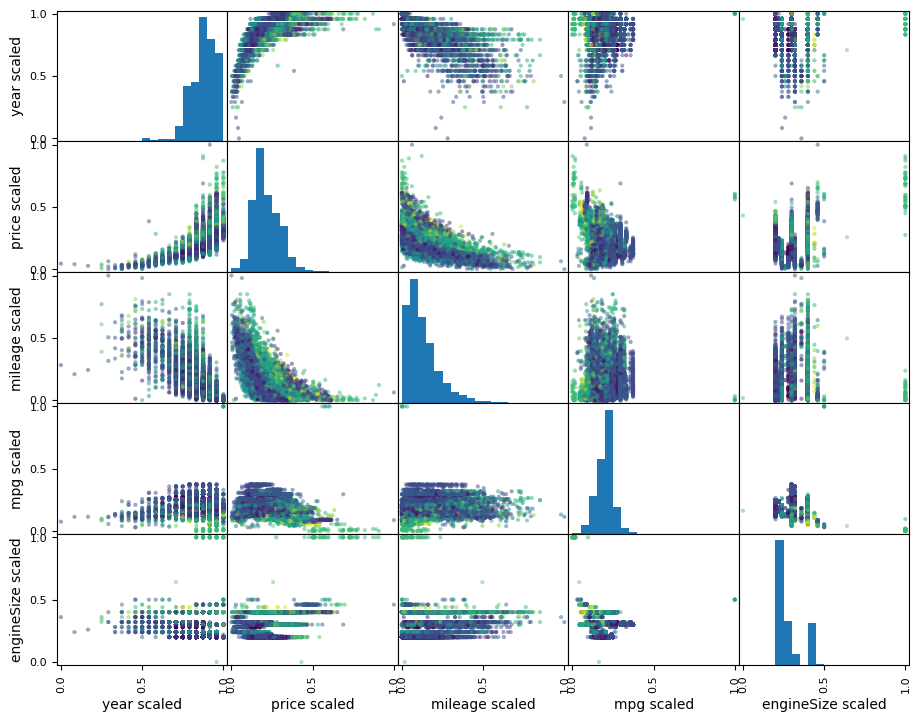

In [87]:
if (gen_new_plot):

    # labels for pairwise plots
    from sklearn.preprocessing._label import LabelEncoder
    
    pd.plotting.scatter_matrix(
        X_scaled[X_scaled.columns[[0,1,2,3,4]]],
        c=LabelEncoder().fit(y).transform(y),
        diagonal='hist',
        hist_kwds={'bins':20},
        figsize=(11, 8.5),
    )
    plt.show()
else:
    display(Image(filename=".CompiledKNN/PairPlot.png"))


Divide data into training and test sets

In [88]:
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    X_scaled, y,
    random_state=0
)

In [89]:
display(X_train_scaled.shape, y_train.shape)
display(X_test_scaled.shape, y_test.shape)

(13434, 12)

(13434,)

(4479, 12)

(4479,)

--- 

# Section 4: Decision Tree Comparision on Scaled Data

Create a decision tree and a KNN from the dataset and compare accuracies of each model

In [90]:
tree = DecisionTreeClassifier(
    random_state=0
)
knn = KNeighborsClassifier()


# import the scaled data and split into training and test sets
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(
    pd.read_csv("X_scaled.csv"), 
    pd.read_csv("y.csv"), 
    random_state=0
)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

tree.fit(X_train_scaled, y_train)
knn.fit(X_train_scaled, y_train)

# hacky way to clear the output
display() 

In [91]:
print("Accuracies on the test set")
print("tree accuracy: " + str(tree.score(X_test_scaled, y_test)))
print("knn accuracy: " + str(knn.score(X_test_scaled, y_test)))
print("training accuracy for tree: " + str(tree.score(X_train_scaled, y_train)))
print("training accuracy for knn: " + str(knn.score(X_train_scaled, y_train)))

Accuracies on the test set
tree accuracy: 0.9229738780977896
knn accuracy: 0.8374637195802634
training accuracy for tree: 1.0
training accuracy for knn: 0.8944469257108828


---

# Final Model
Read in the modified data to assess the final model

In [92]:
features = pd.read_csv("X_scaled_mpg_x_7.0.csv")

In [93]:
y = pd.DataFrame(y, columns=["model"])
models = y.model.unique().tolist()
print(models)

[' Fiesta', ' Focus', ' Puma', ' Kuga', ' EcoSport', ' C-MAX', ' Mondeo', ' Ka+', ' Tourneo Custom', ' S-MAX', ' B-MAX', ' Edge', ' Tourneo Connect', ' Grand C-MAX', ' KA', ' Galaxy', ' Mustang', ' Grand Tourneo Connect', ' Fusion', ' Ranger', ' Streetka', ' Escort', ' Transit Tourneo']


In [94]:
# target = y.to_numpy().ravel()
target = y

In [95]:
indexes = np.empty(shape=0, dtype=np.uint16)

display(target.shape[0])

for model in models:
    mask = (target.model == model)
    if (target[mask].shape[0] <= 50):
        index = target[mask].index[:]
        print(model, "- remove", index.shape[0], "record(s)")
        indexes = np.append(indexes, index)

target = target.drop(index=indexes, axis=0)
features = features.drop(index=indexes, axis=0)

display(target.shape[0])


features.to_csv("features.csv", index=False)
target.to_csv("target.csv", index=False)

17913

 Tourneo Connect - remove 33 record(s)
 Fusion - remove 16 record(s)
 Ranger - remove 1 record(s)
 Streetka - remove 2 record(s)
 Escort - remove 1 record(s)
 Transit Tourneo - remove 1 record(s)


17859

---


In [96]:
display(tree.feature_importances_)
display(tree.feature_names_in_)

array([5.94985766e-02, 1.29441118e-01, 5.41768559e-02, 4.89364042e-01,
       1.90763256e-01, 2.87578161e-03, 4.99218184e-02, 2.81716110e-03,
       7.00854295e-04, 0.00000000e+00, 1.61831436e-04, 2.02787051e-02])

array(['year scaled', 'price scaled', 'mileage scaled', 'mpg scaled',
       'engineSize scaled', 'Automatic scaled', 'Manual scaled',
       'Semi-Auto scaled', 'Diesel scaled', 'Electric scaled',
       'Hybrid scaled', 'Petrol scaled'], dtype=object)